[Gold Explanation](https://www.kaggle.com/code/seyered/eda-novozymes-enzyme-stability) <br>
[Deletion-Specific Ensemble](https://www.kaggle.com/code/oxzplvifi/deletion-specific-ensemble) <br>
[Leading Approaches](https://www.kaggle.com/code/dschettler8845/novo-esp-eli5-performant-approaches-lb-0-451?scriptVersionId=107187300) <br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

import matplotlib
import lightgbm
matplotlib.style.use('ggplot')

from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale
from lightgbm import LGBMRegressor

import math
import itertools
import bisect
import collections
import functools
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import OrthogonalMatchingPursuitCV
import Levenshtein
import biopandas
from biopandas.pdb import PandasPdb

In [2]:
# Load the training, testing and submission data
TRAIN = "trainsrc.csv"
TEST = "testsrc.csv"

train_df = pd.read_csv(TRAIN, index_col=0).dropna()
test_df = pd.read_csv(TEST, index_col=0).dropna()

print(f'Training set size {train_df.shape}')
print(f'Test set size     {test_df.shape}')

Training set size (27769, 4)
Test set size     (2413, 3)


In [3]:
display(train_df.head())
display(test_df.head())

,protein_sequence,pH,data_source,tm
seq_id,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


,protein_sequence,pH,data_source
seq_id,,,
31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes
31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes


In [4]:
train_df = train_df.loc[:,['protein_sequence','pH','tm']]
display(train_df)

,protein_sequence,pH,tm
seq_id,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5
...,...,...,...
31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8
31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2
31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6


In [5]:
count_unique = lambda ps : len(set(ps))
train_df['sequence_size'] = train_df['protein_sequence'].apply(len)
train_df['num_unique'] = train_df['protein_sequence'].apply(count_unique)
display(train_df)

,protein_sequence,pH,tm,sequence_size,num_unique
seq_id,,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341,20
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286,19
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497,20
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,265,20
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5,1451,20
...,...,...,...,...,...
31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8,549,20
31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2,469,20
31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6,128,20


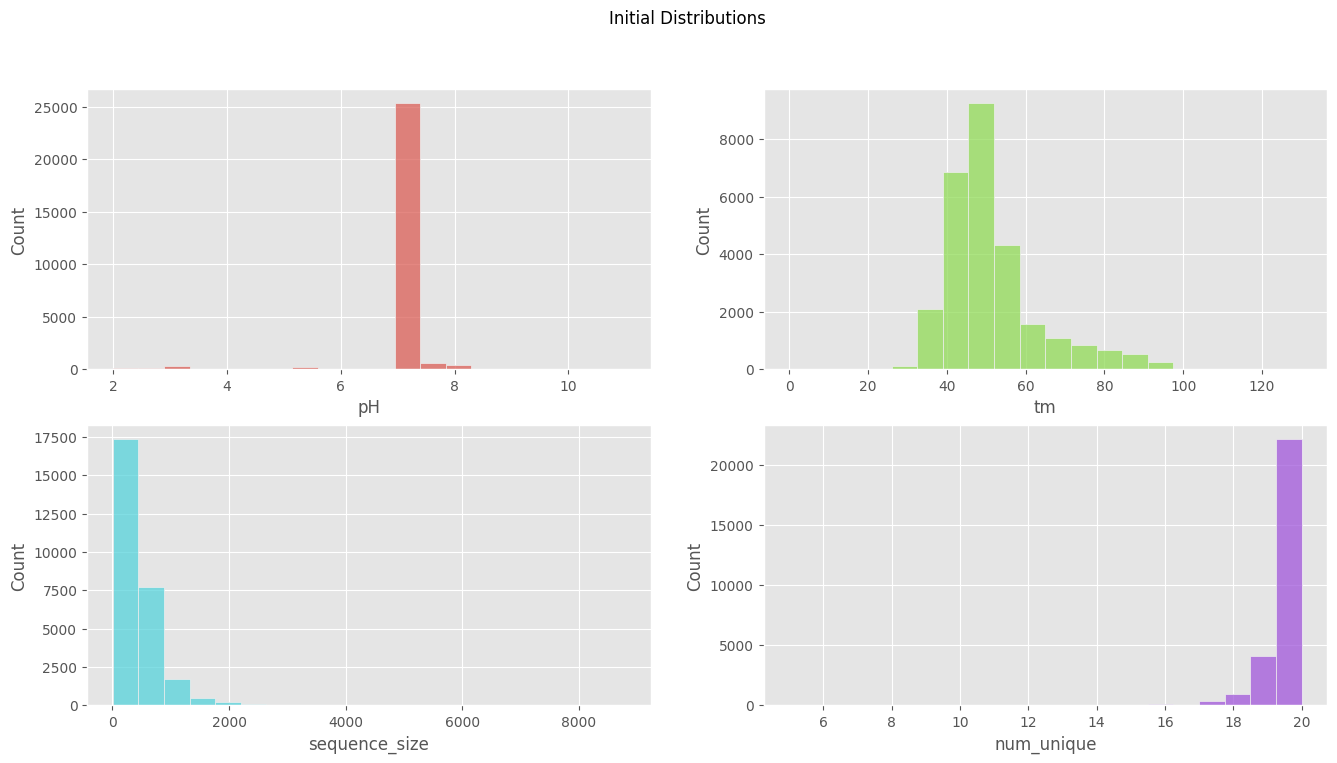

In [6]:
color_gen = (c for c in sns.hls_palette(8)[::2])
cols = ['pH','tm','sequence_size','num_unique']
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(16,8))
for col, ax in zip(cols, axs.flatten()):
    sns.histplot(data=train_df, x=col, bins=20, ax=ax, color=next(color_gen))
plt.suptitle('Initial Distributions')
plt.show()

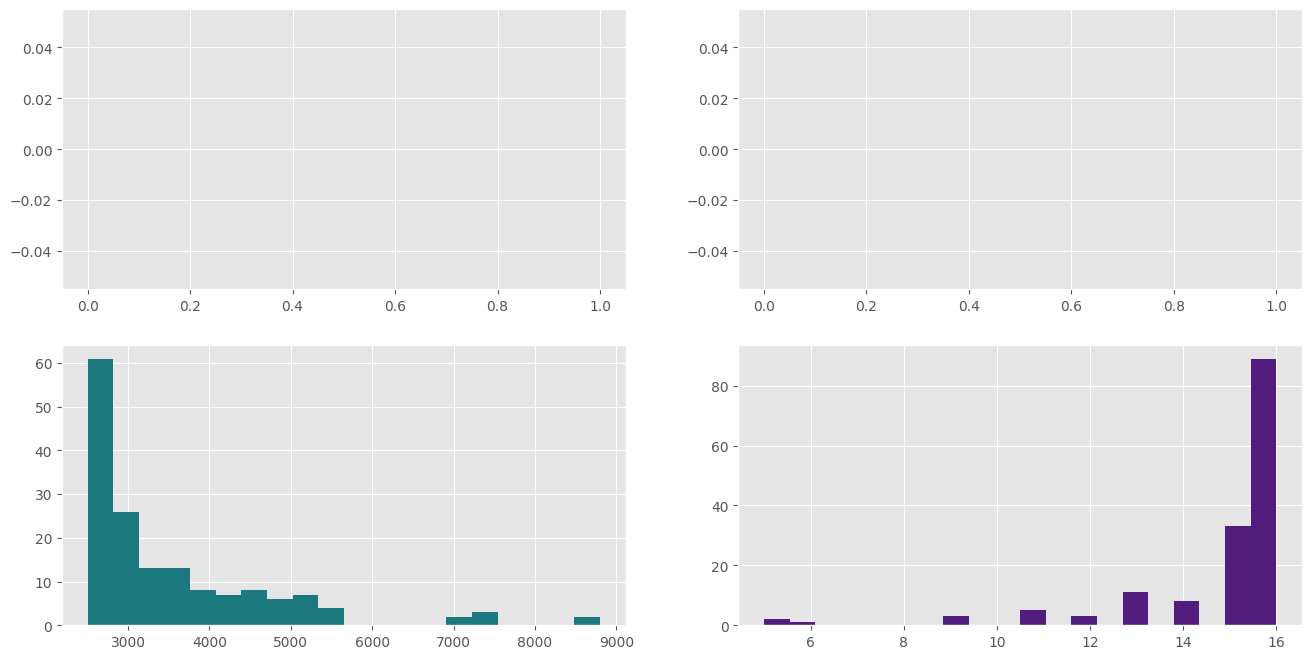

In [7]:
c1, c2, c3, c4 = sns.hls_palette(8, l=.3)[::2]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(16,8))

train_df.loc[train_df['pH'] > 12,'pH'].hist(bins=20, ax=ax1, color=c1)
train_df.loc[(train_df['tm'] <= 0) & (train_df['tm'] > 105),'tm'].hist(bins=20, ax=ax2, color=c2)
train_df.loc[(train_df['sequence_size'] >= 2500),'sequence_size'].hist(bins=20, ax=ax3, color=c3)
train_df.loc[(train_df['num_unique'] < 17),'num_unique'].hist(bins=20, ax=ax4, color=c4)

plt.show()

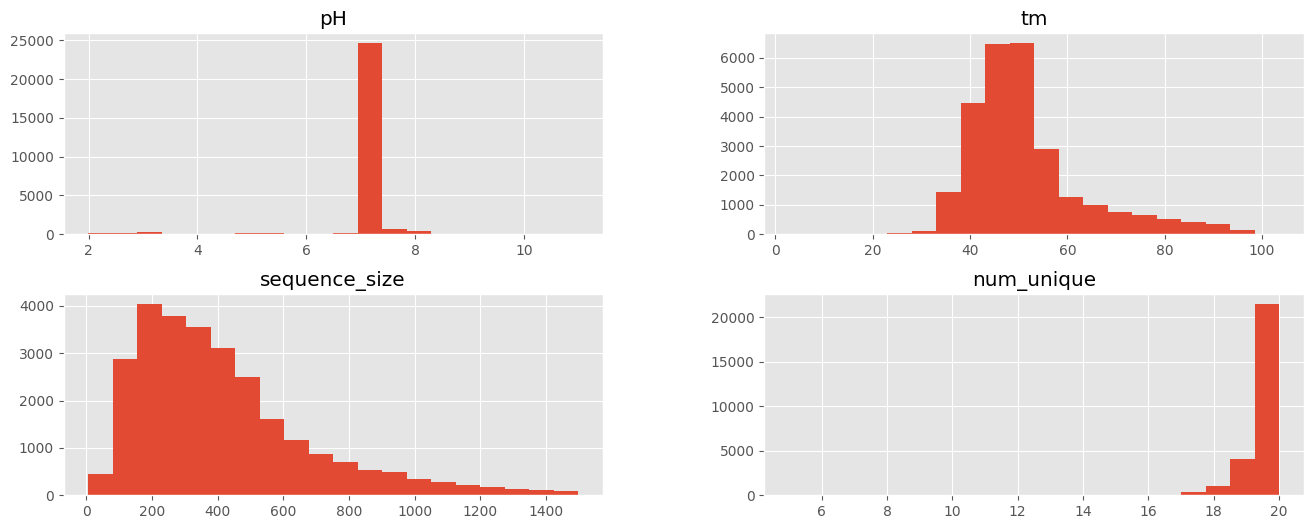

,pH,tm,sequence_size,num_unique
count,27066.000000,27066.000000,27066.000000,27066.000000
mean,6.910177,51.507057,413.721237,19.709192
std,0.727092,12.130660,268.730440,0.705369
min,1.990000,2.800000,5.000000,5.000000
25%,7.000000,43.700000,216.000000,20.000000
50%,7.000000,48.800000,351.000000,20.000000
75%,7.000000,54.700000,526.000000,20.000000
max,11.000000,103.500000,1499.000000,20.000000


In [8]:
train_df = train_df.loc[(train_df['pH'] < 12) & (train_df['tm'] > 0) & (train_df['tm'] < 105) & (train_df['sequence_size'] < 1500),:]
train_df.hist(bins=20, figsize=(16,6))
plt.show()
display(train_df.describe())

Total number of characters: 11197779


'A C D E F G H I K L M N P Q R S T V W Y'

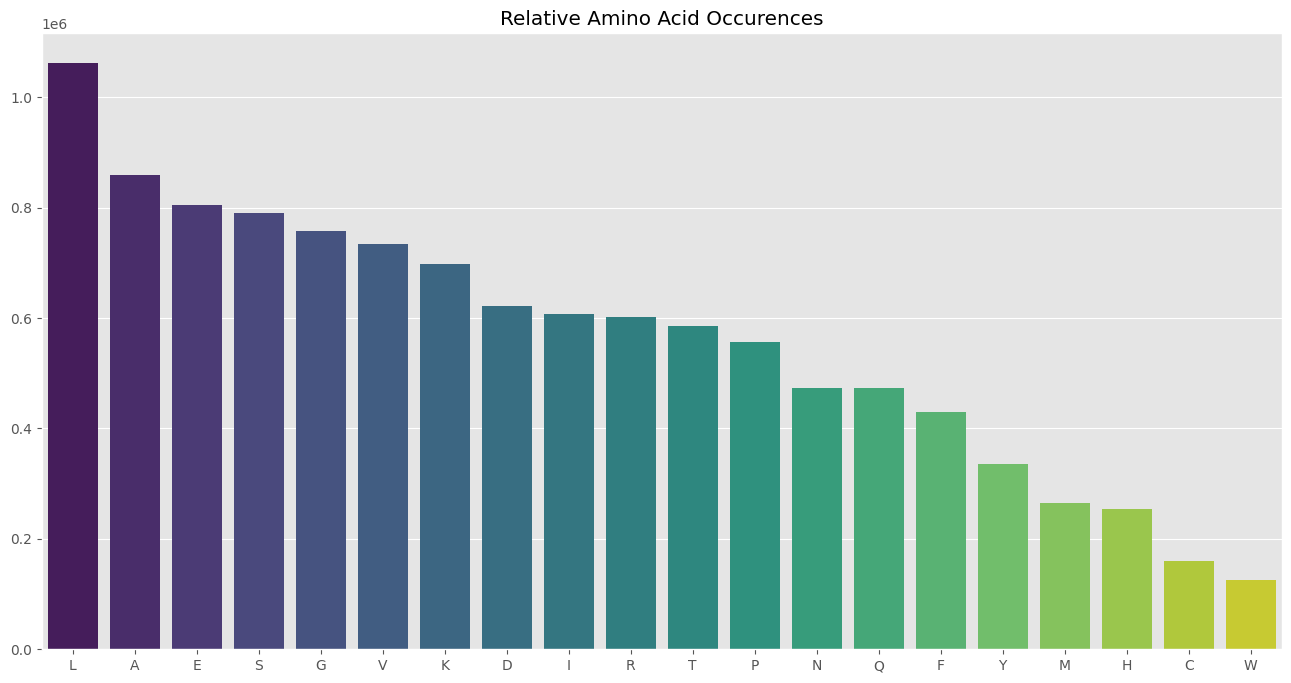

L occurences: 1062834, A occurences: 859429, E occurences: 804890, S occurences: 790513, G occurences: 757227, V occurences: 733818, K occurences: 698179, D occurences: 622796, I occurences: 606809, R occurences: 601799, T occurences: 586012, P occurences: 556587, N occurences: 473266, Q occurences: 473030, F occurences: 429714, Y occurences: 336492, M occurences: 264527, H occurences: 254054, C occurences: 160730, W occurences: 125073, 

In [9]:
full_str = ''.join(train_df['protein_sequence'].tolist())
print('Total number of characters:', len(full_str))

unique_str = sorted(set(full_str))
occurences = [(full_str.count(char), char) for char in unique_str]

display(' '.join(unique_str))
    
plt.figure(figsize=(16,8))
counts, chars = zip(*reversed(sorted(occurences)))
sns.barplot(x=np.array(chars), y=np.array(counts), palette='viridis')
plt.title('Relative Amino Acid Occurences')
# plt.yticks([])
plt.show()

for count, char in reversed(sorted(occurences)):
    print(char, 'occurences:', count, end=', ')

In [10]:


def train_separation(train_df, target='tm', scale_=False):
    y = train_df.loc[:,'tm']
    X = train_df.drop(columns=['tm','protein_sequence'])
    if scale_:
        X_arr = scale(X)
        X = pd.DataFrame(X_arr, index=X.index, columns=X.columns)
    return X, y

X, y = train_separation(train_df)

def model_score(model, X, y, print_=True):
    model.fit(X, y)
    y_hat = model.predict(X)
    r_in, p_in = st.spearmanr(y, y_hat)

    if print_:
        print('Spearman R in sample score:', r_in)
#         print('P value in sample score:', p_in)
    return model, y_hat, r_in, p_in

linreg = LinearRegression(copy_X=False, n_jobs=-1)
ensreg = LGBMRegressor()

_ = model_score(linreg, X, y)
_ = model_score(ensreg, X, y)

Spearman R in sample score: 0.2120457528745706
Spearman R in sample score: 0.3242256668125129


In [11]:
from copy import deepcopy

MIN_LIKELIHOOD = .05

single_permutations = deepcopy(unique_str)
double_permutations = np.concatenate([[(i + j) for i in unique_str] for j in unique_str])
print(single_permutations)
print(sorted(double_permutations))

['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
['AA', 'AC', 'AD', 'AE', 'AF', 'AG', 'AH', 'AI', 'AK', 'AL', 'AM', 'AN', 'AP', 'AQ', 'AR', 'AS', 'AT', 'AV', 'AW', 'AY', 'CA', 'CC', 'CD', 'CE', 'CF', 'CG', 'CH', 'CI', 'CK', 'CL', 'CM', 'CN', 'CP', 'CQ', 'CR', 'CS', 'CT', 'CV', 'CW', 'CY', 'DA', 'DC', 'DD', 'DE', 'DF', 'DG', 'DH', 'DI', 'DK', 'DL', 'DM', 'DN', 'DP', 'DQ', 'DR', 'DS', 'DT', 'DV', 'DW', 'DY', 'EA', 'EC', 'ED', 'EE', 'EF', 'EG', 'EH', 'EI', 'EK', 'EL', 'EM', 'EN', 'EP', 'EQ', 'ER', 'ES', 'ET', 'EV', 'EW', 'EY', 'FA', 'FC', 'FD', 'FE', 'FF', 'FG', 'FH', 'FI', 'FK', 'FL', 'FM', 'FN', 'FP', 'FQ', 'FR', 'FS', 'FT', 'FV', 'FW', 'FY', 'GA', 'GC', 'GD', 'GE', 'GF', 'GG', 'GH', 'GI', 'GK', 'GL', 'GM', 'GN', 'GP', 'GQ', 'GR', 'GS', 'GT', 'GV', 'GW', 'GY', 'HA', 'HC', 'HD', 'HE', 'HF', 'HG', 'HH', 'HI', 'HK', 'HL', 'HM', 'HN', 'HP', 'HQ', 'HR', 'HS', 'HT', 'HV', 'HW', 'HY', 'IA', 'IC', 'ID', 'IE', 'IF', 'IG', 'IH', 'II', 'IK', 'IL'

,protein_sequence,pH,tm,sequence_size,num_unique
seq_id,,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341,20
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286,19
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497,20
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,265,20
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5,1451,20
...,...,...,...,...,...
31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8,549,20
31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2,469,20
31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6,128,20


Train DF with single sequence count


,protein_sequence,pH,tm,sequence_size,num_unique,A,C,D,E,F,...,MY,NY,PY,QY,RY,SY,TY,VY,WY,YY
seq_id,,,,,,,,,,,,,,,,,,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341,20,45,1,13,30,13,...,0,0,1,0,0,0,0,1,0,0
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286,19,28,0,10,52,6,...,0,1,0,0,0,0,0,0,0,0
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497,20,50,9,27,32,21,...,0,0,0,1,1,1,1,1,0,2
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,265,20,20,5,19,29,12,...,0,1,0,0,0,0,0,0,0,0
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5,1451,20,86,14,78,78,32,...,0,1,2,0,3,5,2,2,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8,549,20,33,12,38,31,18,...,1,0,3,1,0,0,0,1,1,2
31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2,469,20,37,5,21,29,22,...,0,1,1,0,1,1,2,1,0,1
31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6,128,20,13,1,7,7,7,...,0,0,0,0,0,1,0,0,0,1


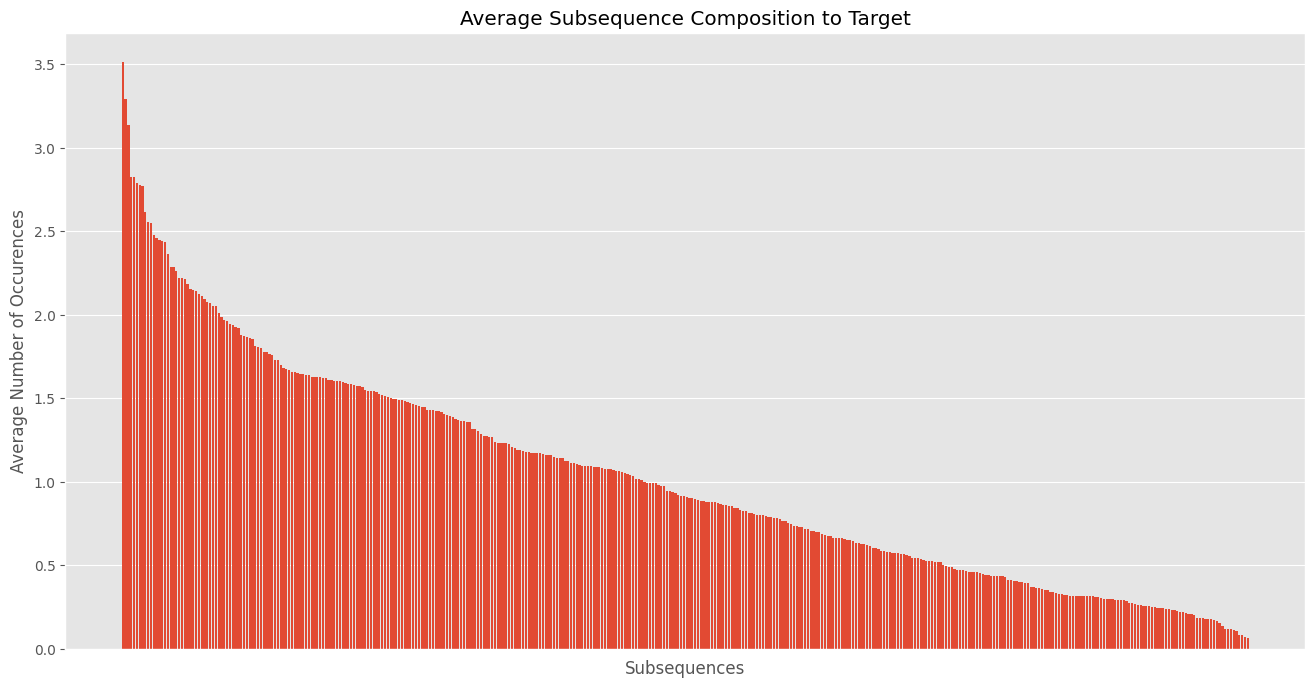

In [12]:
def simple_permute(df):
    for single_permutation in single_permutations:
        df[single_permutation] = [sequence.count(single_permutation) for sequence in df['protein_sequence']]

    permuted_cols = [df]
    for double_permutation in double_permutations:
        dp = df['protein_sequence'].apply(lambda x : x.count(double_permutation))
        dp.name = double_permutation
        permuted_cols.append(dp)

    new_df = pd.concat(permuted_cols, axis=1)
    return new_df

display(train_df)
permuted_train_df1 = simple_permute(train_df.copy())
print('Train DF with single sequence count')
display(permuted_train_df1)
dp_averages = [(permuted_train_df1[dp].mean(), dp) for dp in double_permutations]

def barplot_cols(df, cols):
    plt.figure(figsize=(16,8))
    avgs, sps = zip(*reversed(sorted(cols)))
    plt.bar(sps, avgs)
    plt.xticks([])
    plt.title('Average Subsequence Composition to Target')
    plt.xlabel('Subsequences')
    plt.ylabel('Average Number of Occurences')
    plt.show()
    
barplot_cols(permuted_train_df1, dp_averages)

In [13]:

subseq_score = collections.namedtuple('SubseqScore','p rho subseq feature_series')

MIN_P = 0

def filter_p(df, q, min_p=.2):
    p_values = np.array([sss.p for sss in q])
    features = np.array([sss.subseq for sss in q])
    filtered_features = features[p_values > min_p]
    new_df = df.loc[:,[col for col in df if col not in features] + filtered_features.tolist()]
    new_df.loc[:,filtered_features] = new_df.loc[:,filtered_features].fillna(0)
    new_df.index.name = 'seq_id'
    return new_df

def split_named(df, col):
    rho, p = st.spearmanr(df.loc[:,col], df.loc[:,'tm'])
    return subseq_score(p, rho, col, df.loc[:,col])            
                          
q = [split_named(permuted_train_df1, col) for col in single_permutations + double_permutations.tolist()]
permuted_train_df1 = filter_p(permuted_train_df1, q, min_p=MIN_P)
display(permuted_train_df1)

,protein_sequence,pH,tm,sequence_size,num_unique,A,C,D,E,F,...,MY,NY,PY,QY,RY,SY,TY,VY,WY,YY
seq_id,,,,,,,,,,,,,,,,,,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341,20,45,1,13,30,13,...,0,0,1,0,0,0,0,1,0,0
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286,19,28,0,10,52,6,...,0,1,0,0,0,0,0,0,0,0
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497,20,50,9,27,32,21,...,0,0,0,1,1,1,1,1,0,2
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,265,20,20,5,19,29,12,...,0,1,0,0,0,0,0,0,0,0
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5,1451,20,86,14,78,78,32,...,0,1,2,0,3,5,2,2,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8,549,20,33,12,38,31,18,...,1,0,3,1,0,0,0,1,1,2
31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2,469,20,37,5,21,29,22,...,0,1,1,0,1,1,2,1,0,1
31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6,128,20,13,1,7,7,7,...,0,0,0,0,0,1,0,0,0,1


In [14]:
def split_spearman(df, col, target='tm', min_rows=3000):
    temp_df = df.loc[df[col] != 0, [col,target]]
    if temp_df.shape[0] < min_rows:
        return 0, 0, col
    rho, p = st.spearmanr(temp_df[col], temp_df[target])
#     print(rho, p, col)
    return abs(rho), p, col

spearman_corrs = [
    split_spearman(permuted_train_df1, col)
    for col 
    in permuted_train_df1 
    if permuted_train_df1[col].dtype in ['int64','float64'] and col != 'tm'
]

<Figure size 1600x800 with 0 Axes>

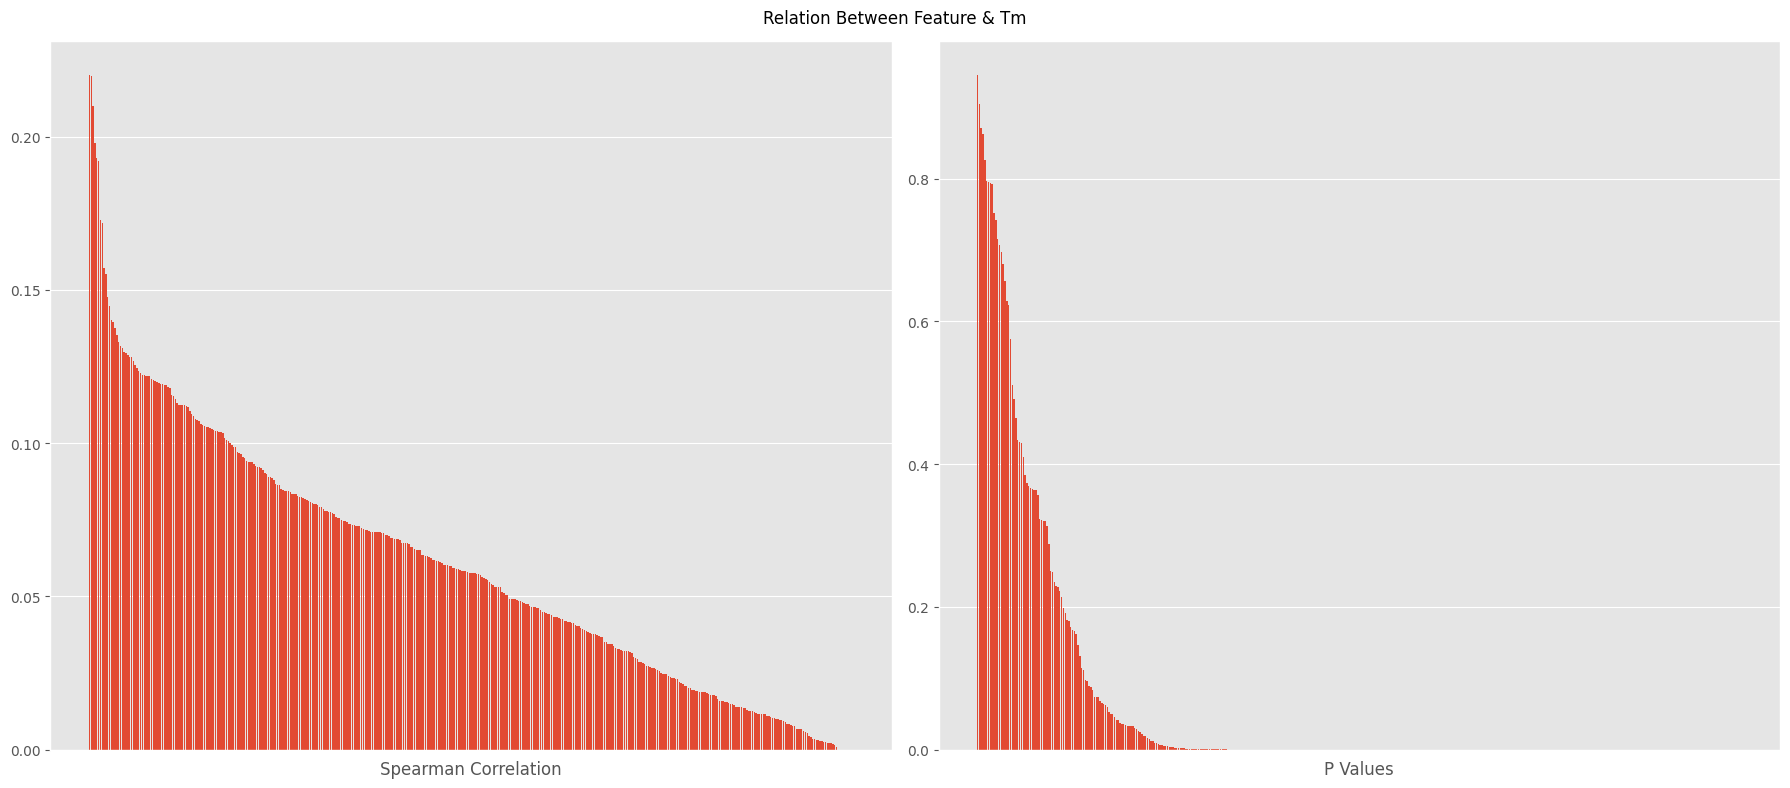

In [15]:
plt.figure(figsize=(16,8))
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(18,8))

sorted_corrs = sorted(spearman_corrs, key=lambda x : x[0])
corrs, ps, cols = zip(*reversed(sorted_corrs))
ax1.set_xticks([])
ax1.bar(cols, corrs)
ax1.set_xlabel('Spearman Correlation')

sorted_ps = sorted(spearman_corrs, key=lambda x : x[1])
corrs, ps, cols = zip(*reversed(sorted_ps))
ax2.set_xticks([])
ax2.bar(cols, ps)
ax2.set_xlabel('P Values')
fig.suptitle('Relation Between Feature & Tm')
plt.tight_layout()
plt.show()

<Figure size 1600x800 with 0 Axes>

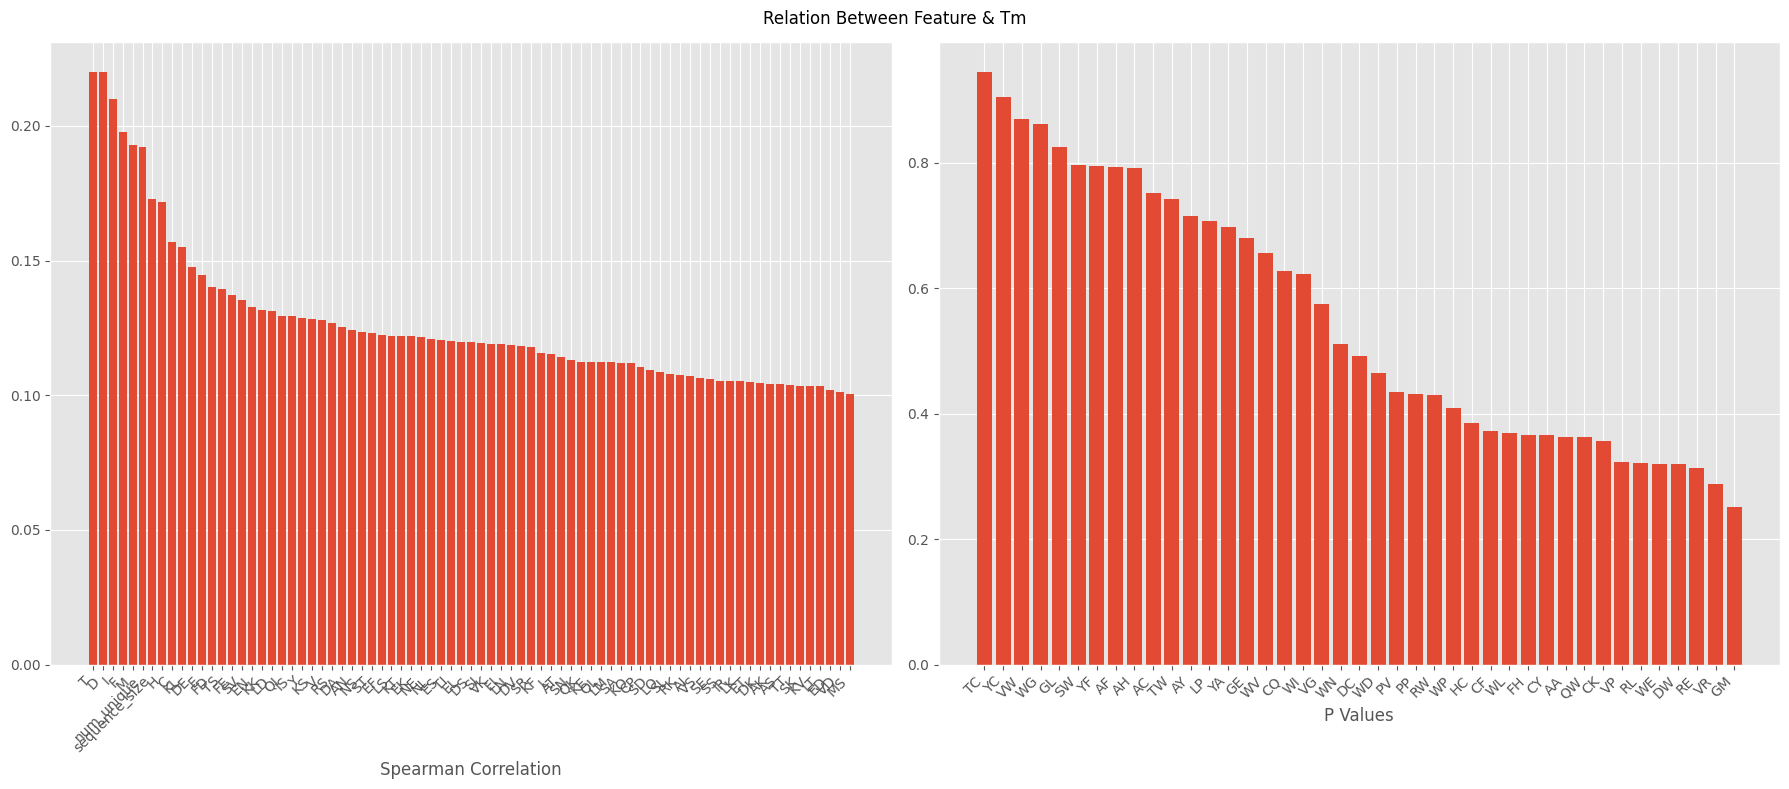

,protein_sequence,pH,tm,sequence_size,num_unique,TC,YC,VW,WG,GL,...,AA,QW,CK,VP,RL,WE,DW,RE,VR,GM
seq_id,,,,,,,,,,,,,,,,,,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341,20,0,0,0,0,4,...,8,0,0,2,5,1,0,2,4,2
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286,19,0,0,0,1,1,...,2,0,0,0,4,1,0,4,0,0
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497,20,1,2,0,0,1,...,6,2,0,3,2,0,0,2,3,0
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,265,20,0,0,0,0,3,...,1,0,0,1,0,1,2,0,1,0
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5,1451,20,1,0,0,0,8,...,4,0,2,9,4,2,2,1,11,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8,549,20,0,0,3,1,3,...,4,2,1,3,2,1,2,2,4,0
31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2,469,20,1,0,0,0,2,...,5,0,0,1,6,1,2,1,1,0
31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6,128,20,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,1


In [16]:
MIN_P = .25
MIN_C = .10
#-----------------------------------------------------------------
plt.figure(figsize=(16,8))
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(18,8))

sorted_corrs = sorted(spearman_corrs, key=lambda x : x[0])
corrs, ps, cols = zip(*reversed(sorted_corrs))
corrs, ps, cols = np.array(corrs), np.array(ps), np.array(cols)

mask = corrs > MIN_C
corrs = corrs[mask]
ps = ps[mask]
cols1 = cols[mask]

ax1.bar(cols1, corrs)
ax1.set_xlabel('Spearman Correlation')
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=45, ha='right')
#-----------------------------------------------------------------
sorted_ps = sorted(spearman_corrs, key=lambda x : x[1])
corrs, ps, cols = zip(*reversed(sorted_ps))
corrs, ps, cols = np.array(corrs), np.array(ps), np.array(cols)

mask = ps > MIN_P
corrs = corrs[mask]
ps = ps[mask]
cols2 = cols[mask]

ax2.bar(cols2, ps)
ax2.set_xlabel('P Values')
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=45, ha='right')

fig.suptitle('Relation Between Feature & Tm')
plt.tight_layout()
plt.show()
#-----------------------------------------------------------------
permuted_train_df1 = permuted_train_df1.loc[:,train_df.columns.tolist() + cols2.tolist()]
display(permuted_train_df1)

In [17]:
N_FEATURES = 50
MIN_ROWS = 5000
MAX_C_LEN = 2 # max length of permutation/combinations to test
    
def best_permutations(df, max_len=3, min_rows=5000, n_features=50, sequence_type='permutations'):
    sps = deepcopy(unique_str)

    q = list()
    pmin = 0

    if sequence_type == 'permutations':
        sequence_func = itertools.permutations
    elif sequence_type == 'combinations':
        sequence_func = itertools.combinations
    else:
        raise ValueError(f'Invalid sequence type {sequence_type}')

    for i in range(1, max_len + 1):
        for c in sequence_func(sps, i):
            subseq = ''.join(c)
            print(subseq, end='\r')
            feature_series = pd.Series([pseq.count(subseq) for pseq in df['protein_sequence']], index=df.index)

            temp_df = df.loc[~feature_series.isnull(),:]
            if temp_df.shape[0] < min_rows: continue

            feature_series = feature_series.loc[temp_df.index]
            feature_series /= temp_df['sequence_size']
            feature_series.name = subseq
            assert not np.nan in feature_series
            assert not np.nan in temp_df['tm']
            rho, p = st.spearmanr(feature_series, temp_df['tm'])
            if p > pmin or len(q) < n_features:
                bisect.insort(q, subseq_score(p, abs(rho), subseq, feature_series))
                if len(q) > n_features:
                    popped = q.pop(0)
                    pmin = q[0].p


    print('q len', len(q))
    print('q2 len', len(q[0]))

    # ps, rhos, subseqs, feature_series_list = zip(*q)
    feature_series_list = [df] + [sss.feature_series for sss in q]

    # print(feature_series_list)
    # feature_series_list.append(df)

    merger = lambda a, b : pd.merge(a, b, left_index=True, right_index=True, how='outer')
    new_feature_df = functools.reduce(merger, feature_series_list).fillna(0)
    return new_feature_df, q

permuted_train_df2, q = best_permutations(train_df.copy(), max_len=MAX_C_LEN, min_rows=MIN_ROWS, n_features=N_FEATURES)
display(permuted_train_df2)

q len 50
q2 len 4


,protein_sequence,pH,tm,sequence_size,num_unique,EP,YW,MA,TP,AD,...,PY,QA,WY,PR,GT,LY,DL,KA,TL,KG
seq_id,,,,,,,,,,,,,,,,,,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341,20,0.002933,0.000000,0.005865,0.000000,0.002933,...,0.002933,0.008798,0.000000,0.005865,0.002933,0.000000,0.000000,0.005865,0.002933,0.002933
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286,19,0.003497,0.000000,0.000000,0.003497,0.003497,...,0.000000,0.017483,0.000000,0.003497,0.003497,0.000000,0.013986,0.006993,0.003497,0.000000
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497,20,0.006036,0.000000,0.000000,0.004024,0.006036,...,0.000000,0.008048,0.000000,0.002012,0.012072,0.000000,0.004024,0.006036,0.002012,0.004024
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,265,20,0.007547,0.000000,0.000000,0.003774,0.007547,...,0.000000,0.003774,0.000000,0.003774,0.003774,0.003774,0.003774,0.007547,0.007547,0.000000
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5,1451,20,0.004135,0.000000,0.001378,0.008959,0.002757,...,0.001378,0.004135,0.000000,0.003446,0.006892,0.004135,0.004824,0.002068,0.007581,0.003446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8,549,20,0.001821,0.000000,0.000000,0.003643,0.005464,...,0.005464,0.001821,0.001821,0.000000,0.005464,0.001821,0.007286,0.001821,0.003643,0.003643
31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2,469,20,0.000000,0.000000,0.002132,0.004264,0.006397,...,0.002132,0.004264,0.000000,0.002132,0.004264,0.002132,0.006397,0.004264,0.004264,0.000000
31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6,128,20,0.000000,0.000000,0.007812,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.007812,0.000000,0.007812,0.015625,0.000000


In [18]:
def scale_features(df):
    numeric_cols = [col for col in df if df[col].dtype in ('float64','int64')]
    for col in numeric_cols:
        df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    return df 

def ensemble_score(df):
    model = LGBMRegressor()
    X, y = train_separation(df)
    _, y_hat, *_ = model_score(model, X, y)   
    return

display(permuted_train_df2.head())
ensemble_score(permuted_train_df2)

,protein_sequence,pH,tm,sequence_size,num_unique,EP,YW,MA,TP,AD,...,PY,QA,WY,PR,GT,LY,DL,KA,TL,KG
seq_id,,,,,,,,,,,,,,,,,,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341,20,0.002933,0.0,0.005865,0.000000,0.002933,...,0.002933,0.008798,0.0,0.005865,0.002933,0.000000,0.000000,0.005865,0.002933,0.002933
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286,19,0.003497,0.0,0.000000,0.003497,0.003497,...,0.000000,0.017483,0.0,0.003497,0.003497,0.000000,0.013986,0.006993,0.003497,0.000000
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497,20,0.006036,0.0,0.000000,0.004024,0.006036,...,0.000000,0.008048,0.0,0.002012,0.012072,0.000000,0.004024,0.006036,0.002012,0.004024
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,265,20,0.007547,0.0,0.000000,0.003774,0.007547,...,0.000000,0.003774,0.0,0.003774,0.003774,0.003774,0.003774,0.007547,0.007547,0.000000
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5,1451,20,0.004135,0.0,0.001378,0.008959,0.002757,...,0.001378,0.004135,0.0,0.003446,0.006892,0.004135,0.004824,0.002068,0.007581,0.003446


Spearman R in sample score: 0.5113112328717663


In [19]:

TRAIN_PER = .8

def plot_feature_importance(model, feature_names=None):
    model_name = model.__class__.__name__
    feature_importances = model.feature_importances_
    if feature_names is None:
        try:
            feature_names = model.feature_names_in_
        except AttributeError:
            feature_names = model.feature_name_
        
    sorted_pairs = sorted(list(zip(feature_importances, feature_names)))
    feature_importances, feature_names = zip(*sorted_pairs)

    plt.figure(figsize=(12,12), dpi=300)
    sns.barplot(x=np.array(feature_importances), y=np.array(feature_names))
    plt.title(model_name)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    plt.show()
    
def multi_model_eval(df, train_per=.8, comp_no_ph=False):
    X, y = train_separation(df, scale_=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y)

#     display(X_train.head(), y_train.head(), X_test.head(), y_test.head())
    
    lasreg, *_ = model_score(LassoCV(), X_train, y_train, print_=False)
    ensreg, *_ = model_score(LGBMRegressor(), X_train, y_train, print_=False)
    randforreg, *_ = model_score(RandomForestRegressor(), X_train, y_train, print_=False)
    ompcv, *_ = model_score(OrthogonalMatchingPursuitCV(), X_train, y_train, print_=False)


    las_pred = lasreg.predict(X_test)
    print('Lasso Spearman R:', st.spearmanr(las_pred, y_test)[0], end='\n\n')

    ens_pred = ensreg.predict(X_test)
    print('LGBM Spearman R:', st.spearmanr(ens_pred, y_test)[0], end='\n\n')

    randfor_pred = randforreg.predict(X_test)
    print('RForest Spearman R:', st.spearmanr(randfor_pred, y_test)[0], end='\n\n')
    
    ompcv_pred = randforreg.predict(X_test)
    print('OMP Spearman R:', st.spearmanr(ompcv_pred, y_test)[0], end='\n\n')
    
    if comp_no_ph:
        ensreg_no_ph, *_ = model_score(LGBMRegressor(), X_train.drop(columns=['pH','sequence_size']), y_train, print_=False)
        randforreg_no_ph, *_ = model_score(RandomForestRegressor(), X_train.drop(columns=['pH','sequence_size']), y_train, print_=False)

        ens_pred_no_ph = ensreg_no_ph.predict(X_test.drop(columns=['pH','sequence_size']))
        print('LGBM w/o pH Spearman R:', st.spearmanr(ens_pred_no_ph, y_test)[0], end='\n\n')

        randfor_no_ph_pred = randforreg_no_ph.predict(X_test.drop(columns=['pH','sequence_size']))
        print('RForest w/o pH Spearman R:', st.spearmanr(randfor_no_ph_pred, y_test)[0], end='\n\n')   
    
    plot_feature_importance(ensreg, feature_names=X_train.columns)
    plot_feature_importance(randforreg, feature_names=X_train.columns)
    return

,protein_sequence,pH,tm,sequence_size,num_unique,TC,YC,VW,WG,GL,...,AA,QW,CK,VP,RL,WE,DW,RE,VR,GM
seq_id,,,,,,,,,,,,,,,,,,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341,20,0,0,0,0,4,...,8,0,0,2,5,1,0,2,4,2
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286,19,0,0,0,1,1,...,2,0,0,0,4,1,0,4,0,0
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497,20,1,2,0,0,1,...,6,2,0,3,2,0,0,2,3,0
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,265,20,0,0,0,0,3,...,1,0,0,1,0,1,2,0,1,0
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5,1451,20,1,0,0,0,8,...,4,0,2,9,4,2,2,1,11,2


,protein_sequence,pH,tm,sequence_size,num_unique,EP,YW,MA,TP,AD,...,PY,QA,WY,PR,GT,LY,DL,KA,TL,KG
seq_id,,,,,,,,,,,,,,,,,,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341,20,0.002933,0.0,0.005865,0.000000,0.002933,...,0.002933,0.008798,0.0,0.005865,0.002933,0.000000,0.000000,0.005865,0.002933,0.002933
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286,19,0.003497,0.0,0.000000,0.003497,0.003497,...,0.000000,0.017483,0.0,0.003497,0.003497,0.000000,0.013986,0.006993,0.003497,0.000000
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497,20,0.006036,0.0,0.000000,0.004024,0.006036,...,0.000000,0.008048,0.0,0.002012,0.012072,0.000000,0.004024,0.006036,0.002012,0.004024
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,265,20,0.007547,0.0,0.000000,0.003774,0.007547,...,0.000000,0.003774,0.0,0.003774,0.003774,0.003774,0.003774,0.007547,0.007547,0.000000
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5,1451,20,0.004135,0.0,0.001378,0.008959,0.002757,...,0.001378,0.004135,0.0,0.003446,0.006892,0.004135,0.004824,0.002068,0.007581,0.003446


Lasso Spearman R: 0.2863702056272764

LGBM Spearman R: 0.38551953049934695

RForest Spearman R: 0.40085497128168024

OMP Spearman R: 0.40085497128168024



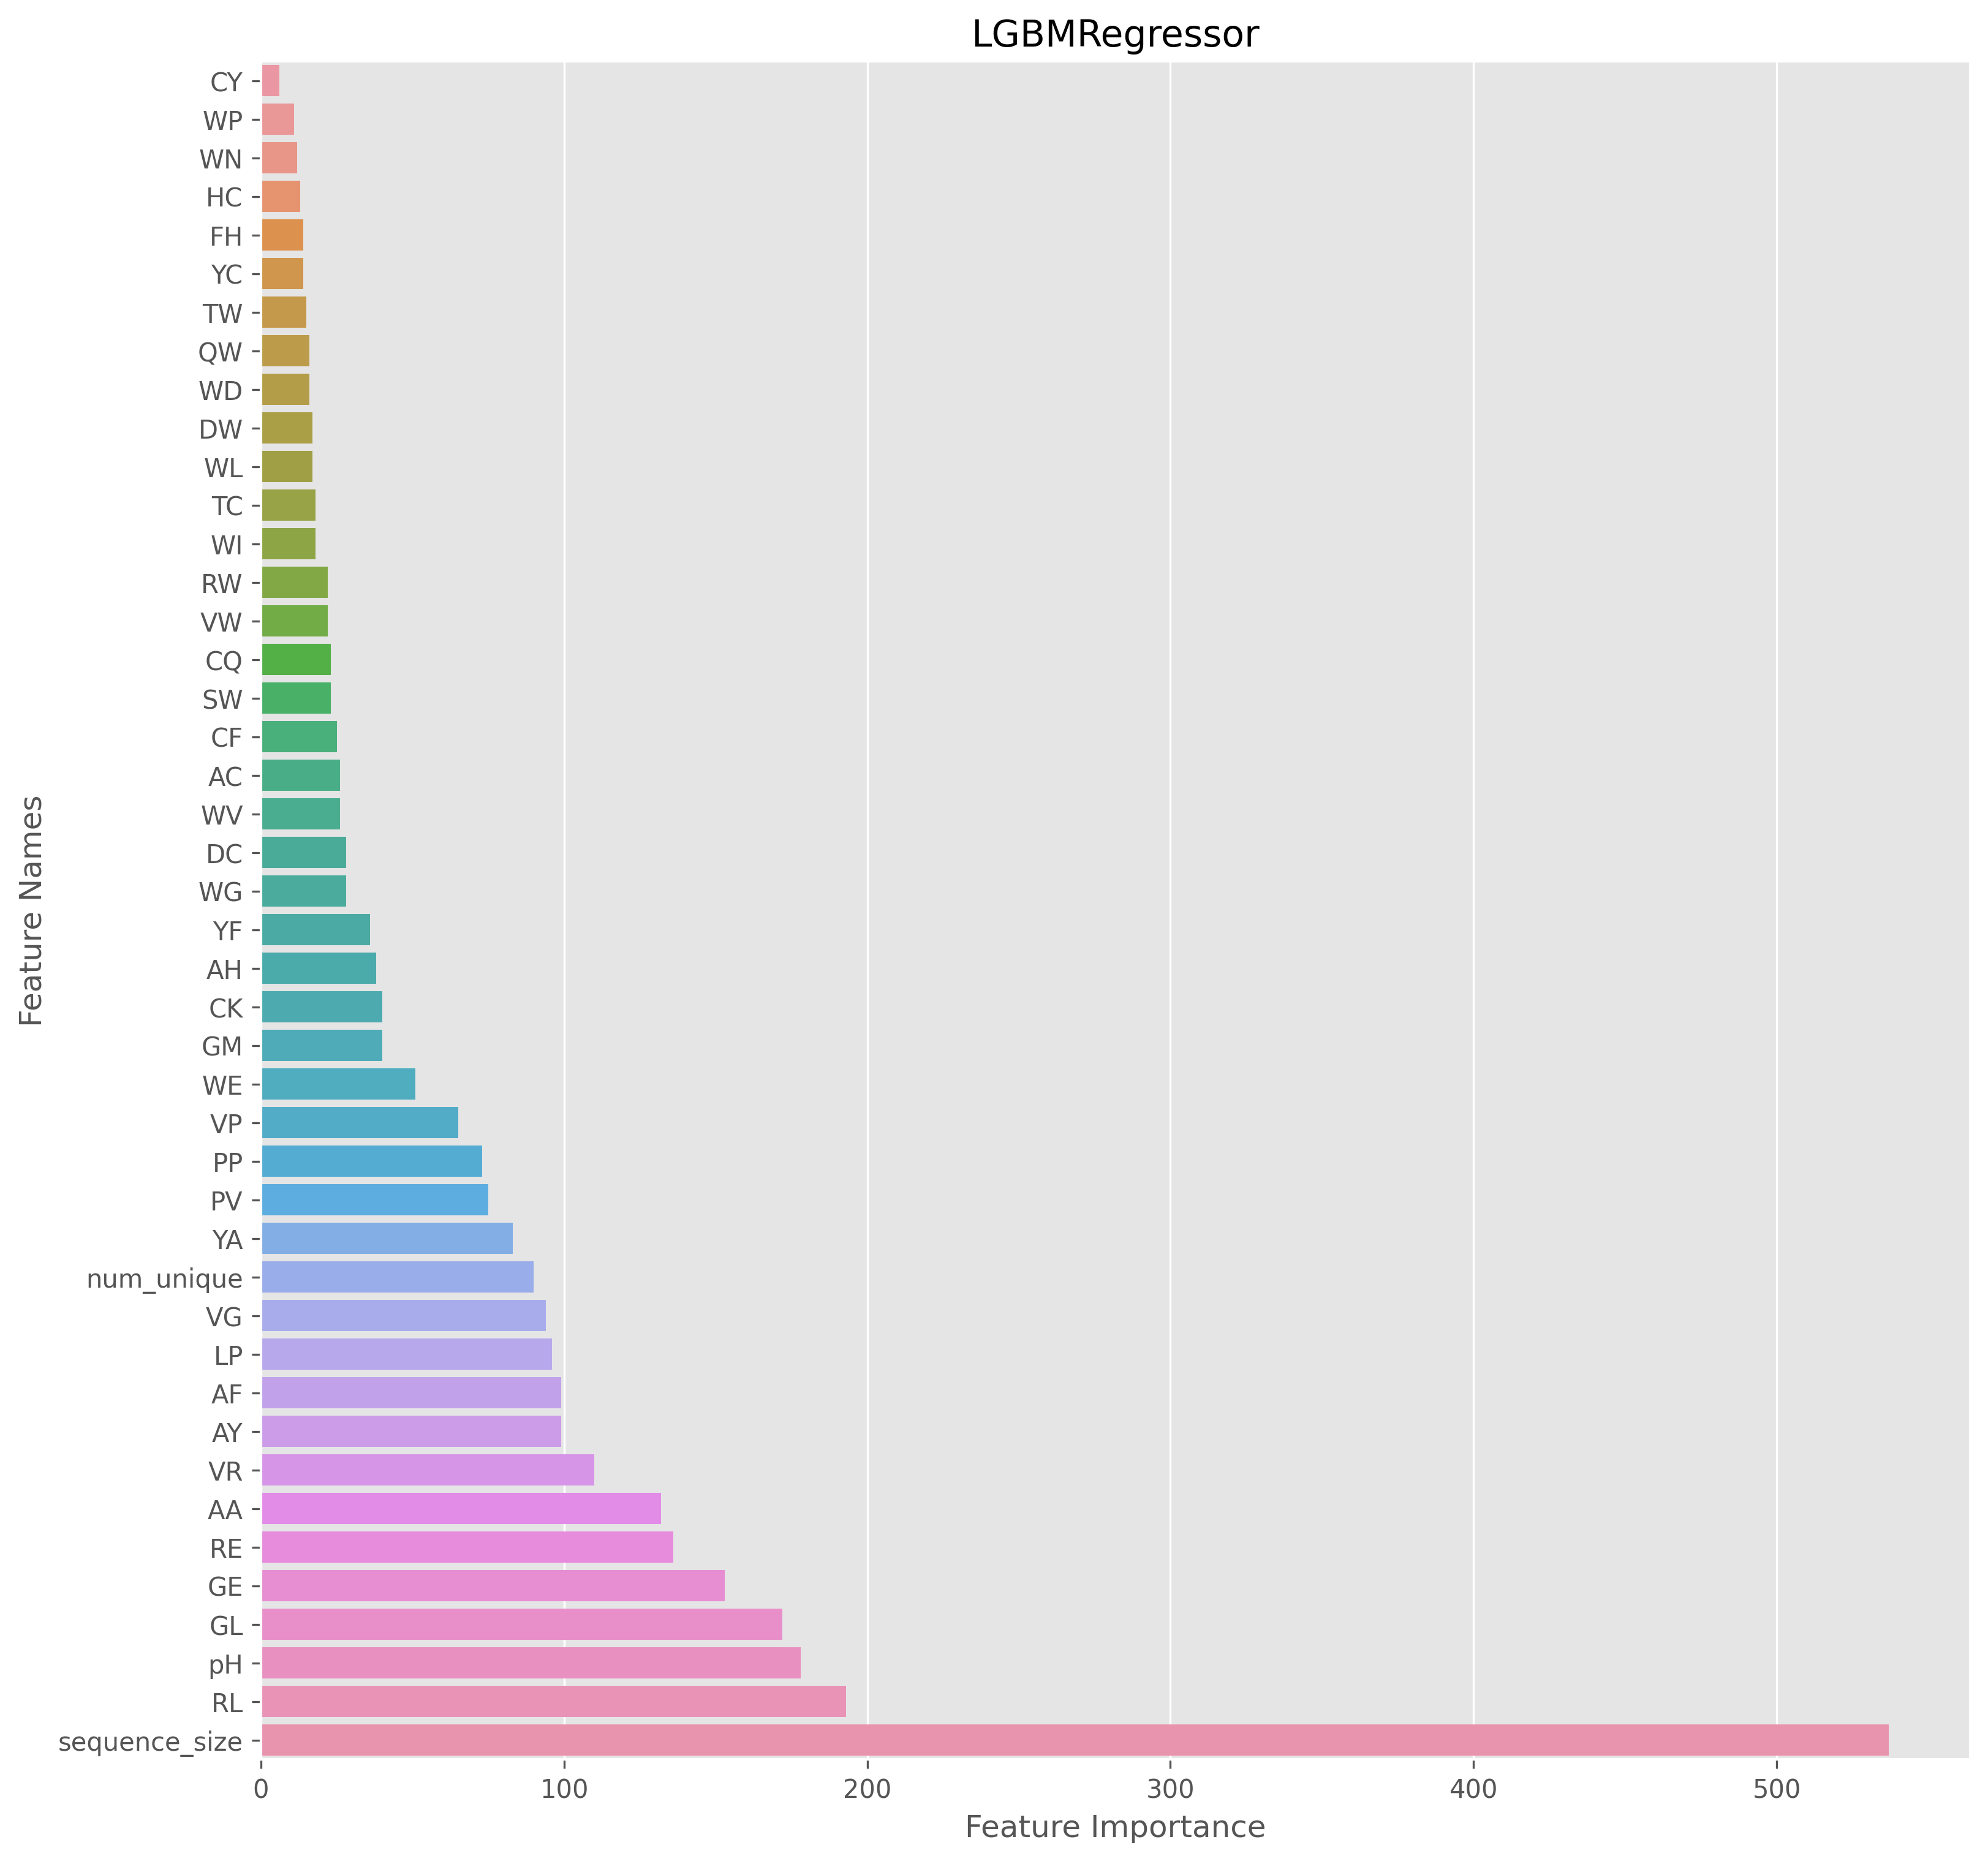

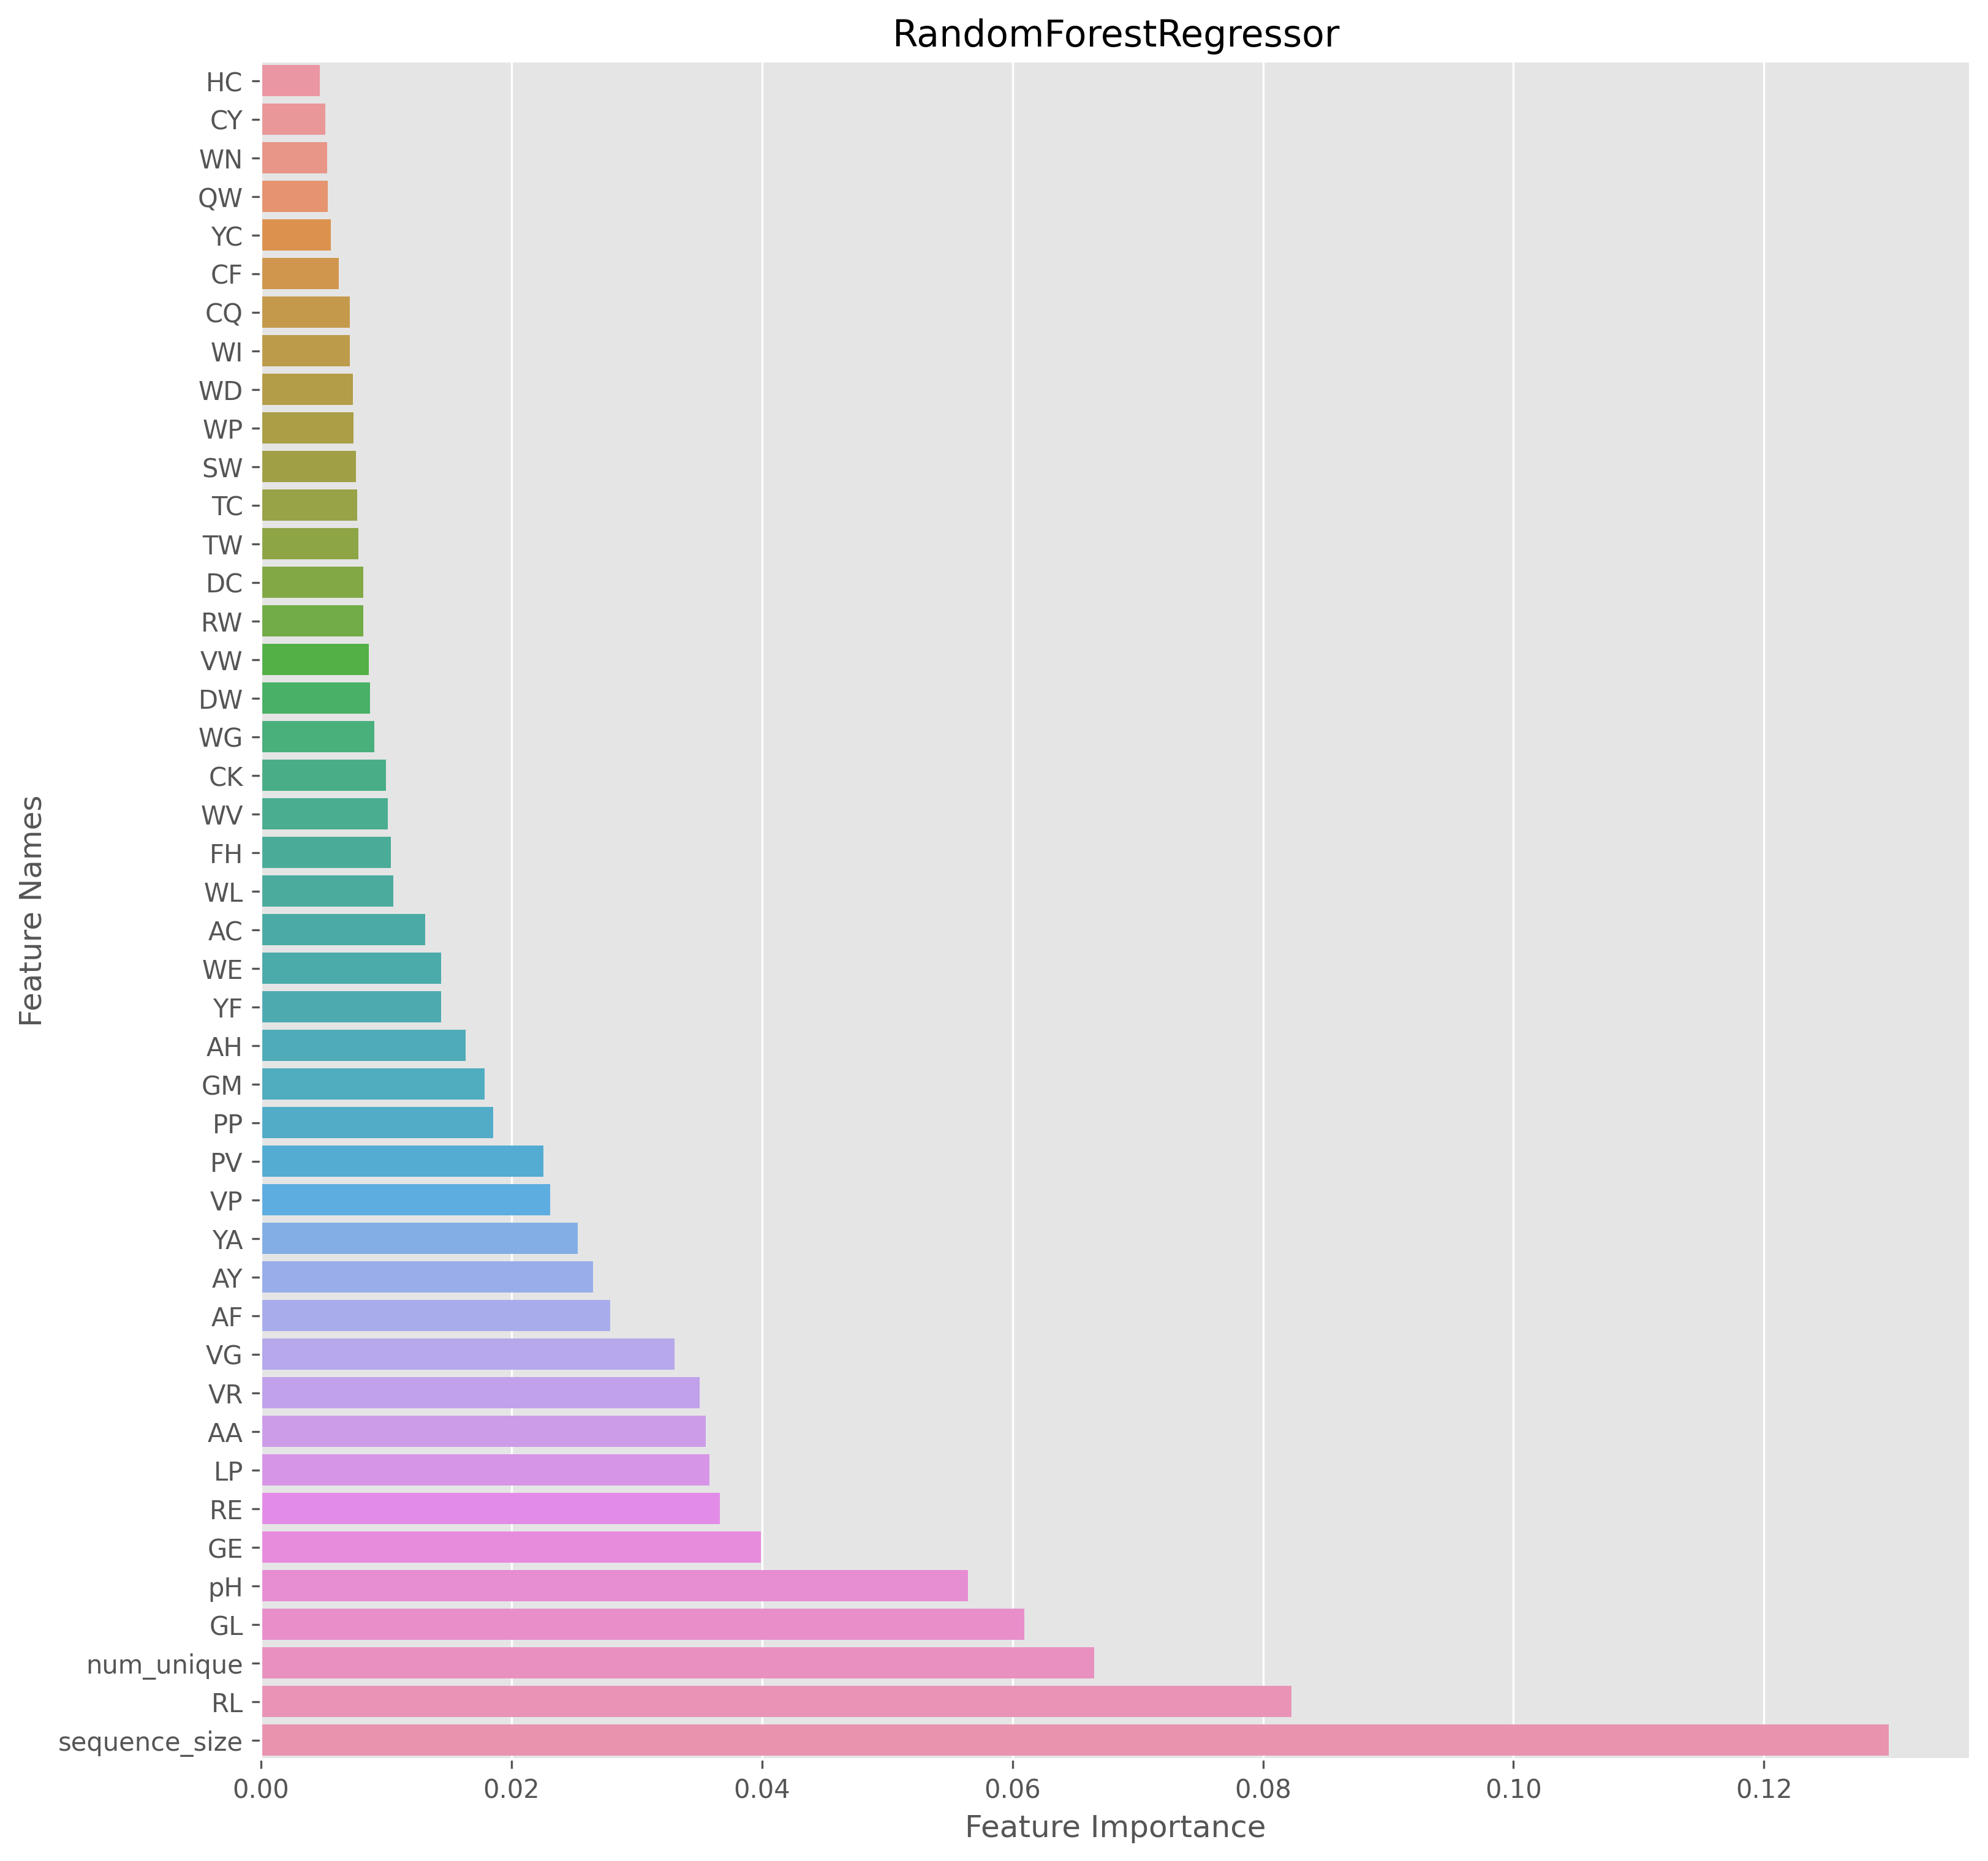

Lasso Spearman R: 0.25934910794342214

LGBM Spearman R: 0.3804917876779571

RForest Spearman R: 0.40470788354476916

OMP Spearman R: 0.40470788354476916



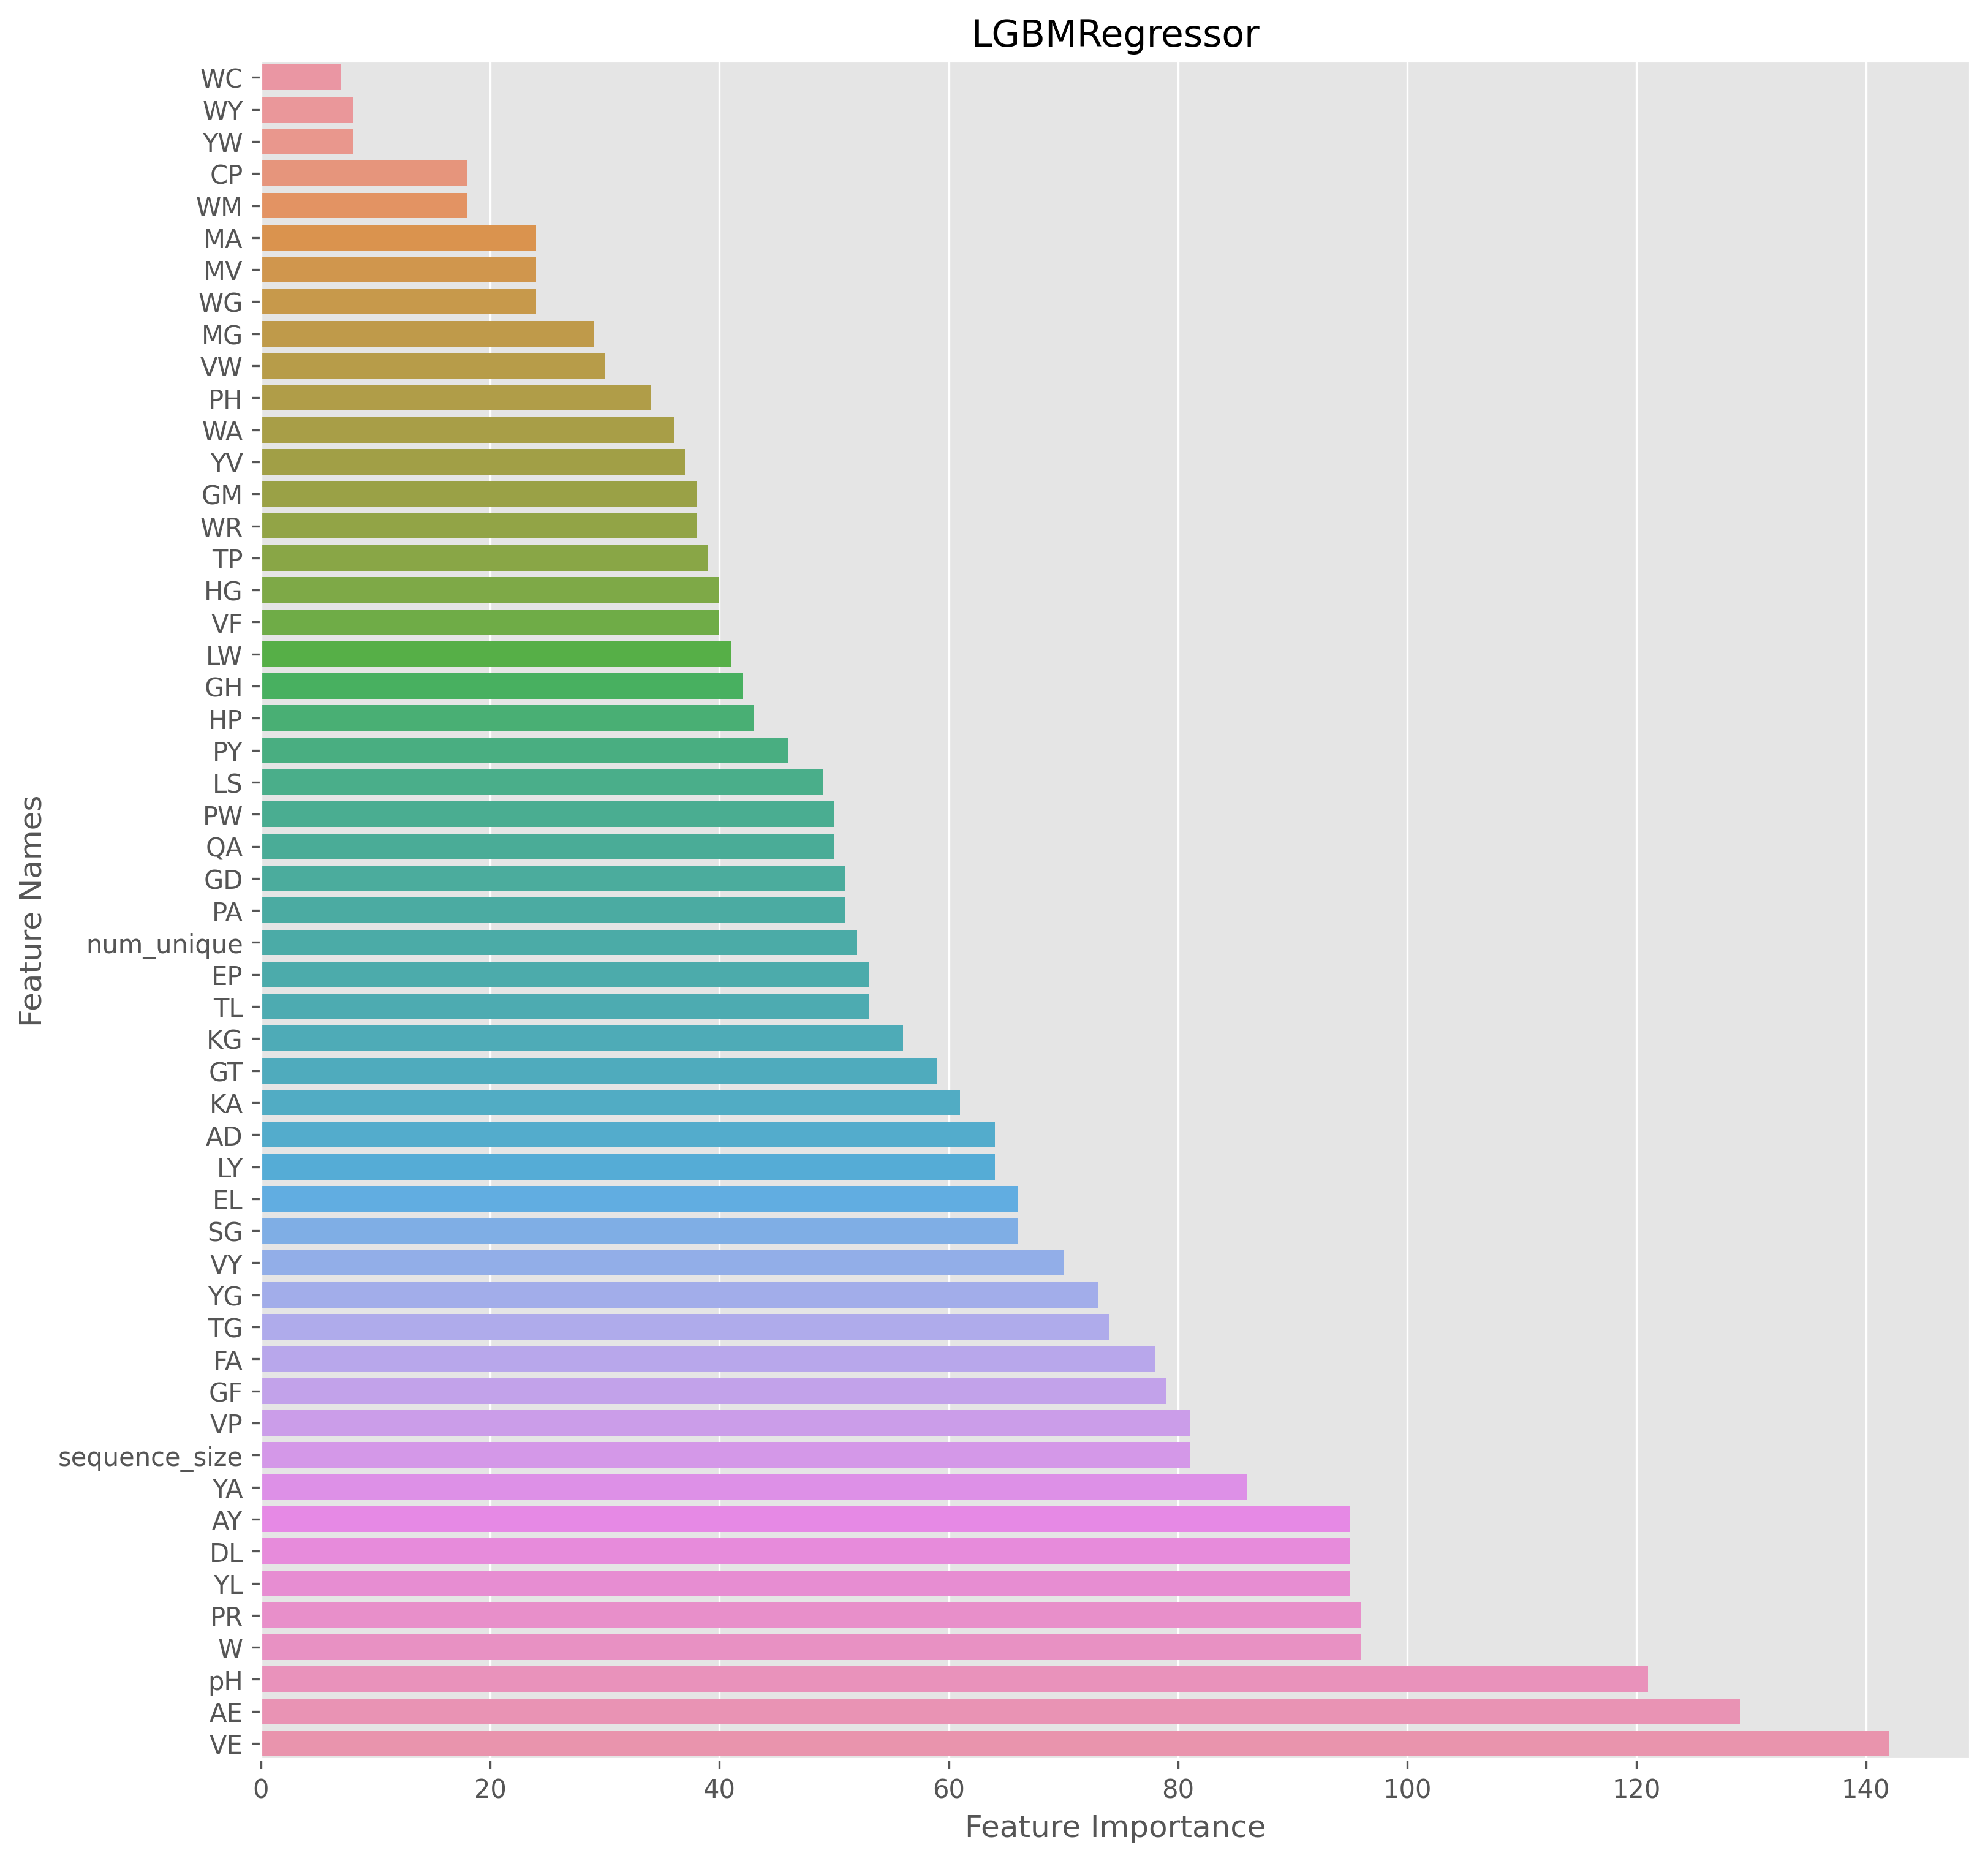

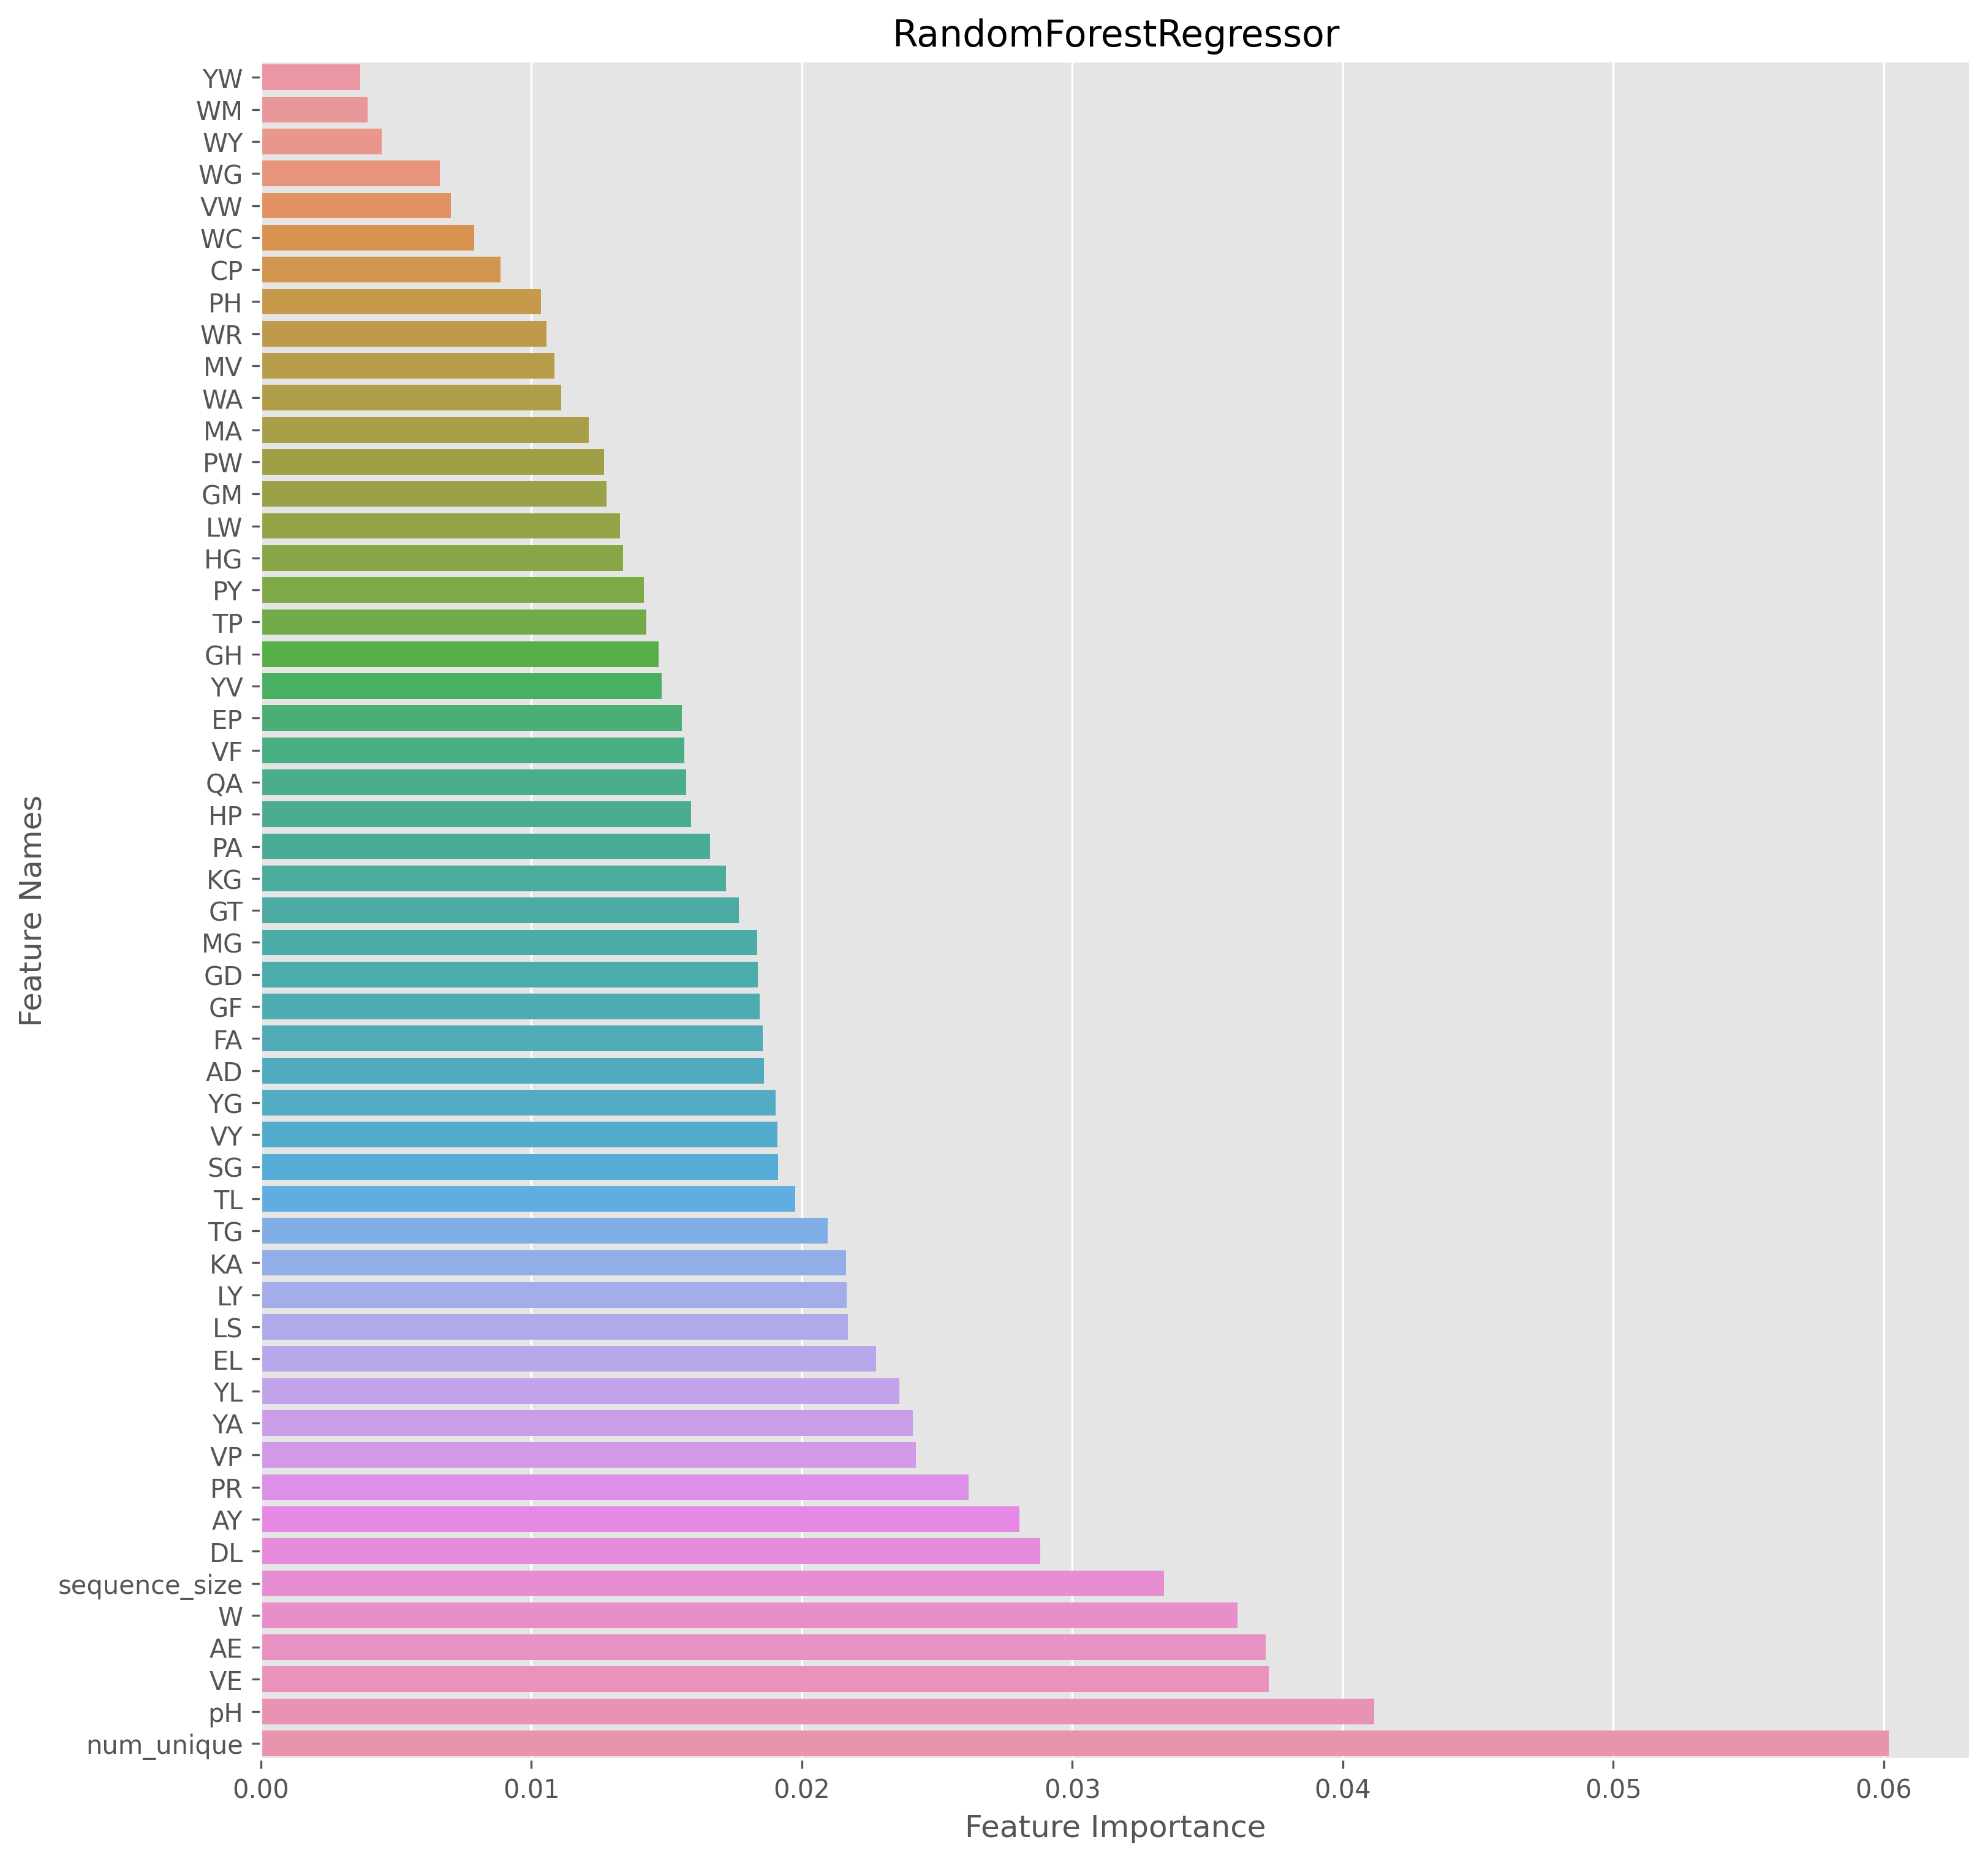

In [20]:
display(permuted_train_df1.head())
display(permuted_train_df2.head())
with warnings.catch_warnings(): #ignore deprecation warning
    warnings.simplefilter('ignore')
    multi_model_eval(permuted_train_df1, train_per=.8, comp_no_ph=False)
    multi_model_eval(permuted_train_df2, train_per=.8, comp_no_ph=False)

In [21]:
BASE = 'VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK'
terminology_map = {"replace":"substitution", "insert":"insertion", "delete":"deletion"}

print(BASE)
print(len(BASE))
print(terminology_map)

bio_train_df = permuted_train_df1.copy()

VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK
221
{'replace': 'substitution', 'insert': 'insertion', 'delete': 'deletion'}


In [22]:

def get_mutation_info(row):
    sequence = row['protein_sequence']
#     try:
#         print(sequence[:10])
#     except TypeError:
#         print(sequence)
    req_edits = Levenshtein.editops(BASE, sequence) if isinstance(sequence, str) else []
#     print(req_edits)
    row["n_edits"] = len(req_edits)
    
    if row["n_edits"]==0:
        row["edit_type"] = row["edit_idx"] = row["wildtype_aa"] = row["mutant_aa"] = pd.NA
    else:
        row["edit_type"] = terminology_map[req_edits[0][0]]
        row["edit_idx"] = req_edits[0][1]
        row["wildtype_aa"] = BASE[row["edit_idx"]]
        row["mutant_aa"] = row["protein_sequence"][req_edits[0][2]] if row["edit_type"]!="deletion" else pd.NA
    return row

bio_train_df = bio_train_df.apply(get_mutation_info, axis=1)

In [23]:

pdb = PandasPdb()

PDB_PATH = 'wildtype_structure_prediction_af2.pdb'
pdb_df = pdb.read_pdb(PDB_PATH)   
atom_df = pdb_df.df['ATOM'].copy()

atom_df['residue_number'] -= 1
residue_to_bfactor_dict = atom_df.groupby('residue_number')['b_factor'].first().to_dict()

bio_train_df['b_factor'] = bio_train_df['edit_idx'].map(residue_to_bfactor_dict)
bio_train_df['edit_type'] = bio_train_df['edit_type'].fillna('no_change')

bio_train_df.loc[bio_train_df['edit_type']=='deletion', 'mutant_aa'] = '-'
bio_train_df.loc[bio_train_df['edit_type']=='insertion', 'mutant_aa'] = '+'
bio_train_df['mutant_string'] = bio_train_df["wildtype_aa"]+bio_train_df["edit_idx"].astype(str)+bio_train_df["mutant_aa"]

In [24]:
# https://www.kaggle.com/code/dschettler8845/novo-esp-eli5-performant-approaches-lb-0-451?scriptVersionId=107187300
# This dataset & corresponding formatting is copied from the above notebook
DDG_PATH = 'wildtype_structure_prediction_af2.deepddg.ddg.txt'
deepddg_pred_df = pd.read_table(DDG_PATH, sep=" ").drop(columns=["#chain", "ddG", "is", "stable,", "is.1", "unstable)", "<0"])
deepddg_pred_df.columns = ["wildtype_aa", "residue_id", "mutant_aa", "ddg", "ddg_"]
deepddg_pred_df["ddg"] = deepddg_pred_df["ddg"].fillna(0.0)+deepddg_pred_df["ddg_"].fillna(0.0)
deepddg_pred_df = deepddg_pred_df.drop(columns=["ddg_"])
deepddg_pred_df['location'] = deepddg_pred_df["residue_id"]-1
deepddg_pred_df = deepddg_pred_df.drop(columns=["residue_id"])
deepddg_pred_df['mutant_string'] = deepddg_pred_df["wildtype_aa"]+deepddg_pred_df["location"].astype(str)+deepddg_pred_df["mutant_aa"]

In [25]:
bio_train_df = bio_train_df.merge(deepddg_pred_df[['ddg','mutant_string']], on='mutant_string', how='left')
bio_train_df.loc[bio_train_df['edit_type']=='deletion', 'ddg'] = -.25 #default for missing vals
bio_train_df.loc[bio_train_df['edit_type']=='no_change', 'ddg'] = 0 #this could be justified differently
bio_train_df

,protein_sequence,pH,tm,sequence_size,num_unique,TC,YC,VW,WG,GL,...,VR,GM,n_edits,edit_type,edit_idx,wildtype_aa,mutant_aa,b_factor,mutant_string,ddg
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341,20,0,0,0,0,4,...,4,2,271,insertion,0,V,+,45.11,V0+,NaN
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286,19,0,0,0,1,1,...,0,0,231,substitution,0,V,A,45.11,V0A,-0.119
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497,20,1,2,0,0,1,...,3,0,397,substitution,0,V,A,45.11,V0A,-0.119
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,265,20,0,0,0,0,3,...,1,0,211,substitution,0,V,A,45.11,V0A,-0.119
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5,1451,20,1,0,0,0,8,...,11,2,1280,insertion,0,V,+,45.11,V0+,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27061,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8,549,20,0,0,3,1,3,...,4,0,441,insertion,0,V,+,45.11,V0+,NaN
27062,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2,469,20,1,0,0,0,2,...,1,0,374,insertion,0,V,+,45.11,V0+,NaN
27063,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6,128,20,0,0,0,0,0,...,1,1,169,substitution,0,V,Y,45.11,V0Y,-0.123
27064,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,50.7,593,20,1,0,0,0,3,...,1,3,477,insertion,0,V,+,45.11,V0+,NaN


In [26]:
# bio_train_df['sub_matrix_score'][bio_train_df['sub_matrix_score'] == 'tbd'] = 0

In [27]:
ldist = lambda x : Levenshtein.distance(BASE, x)
lratio = lambda x : Levenshtein.ratio(BASE, x)

bio_train_df['levenshtein_dist'] = bio_train_df['protein_sequence'].apply(ldist)
bio_train_df['levenshtein_ratio'] = bio_train_df['protein_sequence'].apply(lratio)

In [28]:
from Bio.SubsMat import MatrixInfo

with warnings.catch_warnings(): #ignore deprecation warning
    warnings.simplefilter('ignore')
    sub_matrix = MatrixInfo.blosum100

update_dict = {
    (k[1], k[0]):v 
    for k,v 
    in sub_matrix.items() 
    if (k[1], k[0]) not in list(sub_matrix.keys())
}

sub_matrix.update()

bio_train_df["sub_matrix_tuple"] = bio_train_df[["wildtype_aa", "mutant_aa"]].apply(tuple, axis=1)
bio_train_df["sub_matrix_score"] = bio_train_df["sub_matrix_tuple"].apply(lambda mutant: sub_matrix.get(mutant, 'tbd'))

C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\SubsMat\__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(


In [29]:
bio_train_df.loc[bio_train_df['edit_type']=="deletion", 'sub_matrix_score'] = -10
bio_train_df.loc[bio_train_df['edit_type']=="no_change", 'sub_matrix_score'] = 0
f = lambda x : x if isinstance(x, float) else 0
bio_train_df.loc[:,"sub_matrix_score"] = bio_train_df["sub_matrix_score"].apply(f).astype(float)
bio_train_df.loc[bio_train_df['sub_matrix_score'] > 0, 'sub_score'] = 0

C:\cygwin64\tmp\ipykernel_12036\2494597468.py:4: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  bio_train_df.loc[:,"sub_matrix_score"] = bio_train_df["sub_matrix_score"].apply(f).astype(float)


In [ ]:
from sklearn.model_selection import ShuffleSplit
import joblib

def tune_lgbm(df, save=True):
    if save:
        train, test = train_test_split(df, test_size=0.20, random_state=42)
        train.to_csv('train.csv')
        test.to_csv('test.csv')
    df = df.loc[:,[col for col in df if df[col].dtype in ['int64','float64']]]
    y = df.loc[:,['tm']]
    X = df.loc[:,~df.columns.isin(['protein_sequence','tm'])]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    lgbm_params = {
        'n_estimators' : np.arange(100, 1600, 500),
        'max_depth' : np.arange(2, 18, 4),
        'num_leaves' : np.arange(10, 60, 25),
        'learning_rate' : np.arange(.05, .15, .05),
        'boosting_type' : np.array(['gbdt','dart']),
        'objective' : np.array(['root_mean_squared_error']),
#         'bagging_freq' : np.arange(50, 300, 50),
        'reg_alpha' : np.arange(.25, 1, .25),
        'reg_lambda' : np.arange(.25, 1, .25),
#         'n_jobs' : [-1],
    }
    model = LGBMRegressor()
    model = GridSearchCV(model, lgbm_params, cv=ShuffleSplit(n_splits=7, test_size=0.25, train_size=None))
    model.fit(X_train, y_train)
    print('Final Spearman Correlation:', st.spearmanr(model.predict(X_test), y_test)[0])
    filename = 'model.joblib'
    if save:
        joblib.dump(model, filename)
    return model

tune_lgbm(bio_train_df)